# Locality Sensitive Hash Clustering

Purpose: To meet Aim 1 of our project, implementing fly LSH in python and to test it on a facial image dataset

## 1. Defining the fly LSH 

* ~50 ORNs. which feedforward into an equal amount of PNs
* Center The Mean (Firing rate of ORN is proportional to concentration of odor, this is removed for PN) 
    * all PNs firing rates are close to the mean
    * "standard process" via divisive normalizing (ref 8)
    * prevents mixing up odor intensity with odor type
* ~50 PNs (but equal to the amount of ORNs)
* 2000 KENYON Cells, sparse/randomly connected to 50 PNs
* APL inhibitory neuron, which silences all but the highest activity KC neurons.

## 2. Fly LSH Implementation

In [2]:
import os
import pickle
from typing import Generic

import numpy as np
from scipy.sparse import csr_matrix

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from skimage.io import imread, imshow
from skimage.transform import resize
#from sklearn import neighbors
#from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from bokeh.plotting import figure,output_file,show

# custom src modules
from src import utils

%matplotlib inline

In [3]:
class Flylsh(): #seed: int=42):
    ''' Fly Olfactory Network as proposed by Dasgupta et al 2017.

        :param seed: (int) random seed for numpy random generator
        :param num_orn: (int) number of ORNs for fly input (should be dimension of data)
        :param num_pn: (int) number of PNs - must be same as num_orn
        :param num_kc: (int) number of KCs neurons - default should be 40-fold of num_pc
        :param p_pn_kc: (float) probability of PN->KC connection - default ~6 per

        :return apl: ([csr_matrix, ...]), list of LSH for a single datum input.

    '''
    
    @utils.benchmark
    def __init__(self, seed: int=42, 
                 num_orn: int=50,
                 num_pn: int=50,
                 num_kc: int=2000,
                 p_pn_kc: float=0.003):
        np.random.seed(seed)
        self.data = None
        self.labels = None
        self.hashlen = None
        self.orn = np.random.rand(num_orn,)
        self.pn = np.random.rand(num_pn,)
        self.num_kc = num_kc
        self.kc = csr_matrix(np.random.rand(num_kc,num_pn), shape=(num_kc, num_pn))
        # binary probability mask for mean of 6 neurons connected to each Kenyon cell
        self.mask = np.random.choice([0, 1],
                                     size=(self.pn.shape[0],self.kc.shape[0]),
                                     p=[1-p_pn_kc, p_pn_kc])
        #self.W = np.random.rand(self.pn.shape[0], self.kc.shape[0]) * self.mask
        self.W = self.mask
        self.apl = csr_matrix(self.kc,shape=self.kc.shape)
        
    def orn_to_pn(self):
        ''' Center the Mean step. 
        
            self.orn should be a (1-D) column vector,
            
            return: mean_centered column vector
        '''
        return self.orn - np.mean(self.orn, axis=0)
        
    def pn_to_kc(self): # 40-fold expansion
        ''' 40-fold expansion to high-dimensional array. 
        
            self.pn: column vector, same dimensions as self.orn
            self.W: a binary mask, with second dimension a 40-fold increase
            of self.pn[0]
        
            return: larger sparse, randomly connected array 
        '''
        return csr_matrix((self.pn[:, None] * self.W).T)
    
    def wta(self, hashlen: float=0.05):
        ''' Winner Take All inhibition neuron. 
        
            kc to wta (via APL inhibitory neuron).
            
            param: hashlen: how long output hash should be truncated to 
            as fraction of the input data length (5% default)
            '''
        
        # of the 2000 neurons, 295 are currently non-zero
        top_k = int(self.kc.shape[0] * hashlen)

        kc_sum = np.sum(self.kc, axis=1) / self.num_kc    # divide by bin width, for discretization
        #kc_abs = abs(kc_sum)

        #eps = kc_abs[np.argsort(abs(kc_abs))][::-1][top_k-1]
        eps = float(kc_sum[np.argsort(kc_sum)][::-1][top_k-1])
        # selects to kth largest element value. all the rest get turned to zero
        apl = kc_sum
        apl[abs(apl) < eps] = 0
        self.apl = csr_matrix(apl)
        
        return self.apl
     
    #@utils.benchmark
    def FeedForward(self, datum, hashlen: float=0.05):
        self.hashlen = hashlen
        datum = datum.ravel()
        assert datum.shape == self.orn.shape
        # feed inputs into orn
        self.orn = datum
        # orn to pn, center the means
        self.pn = self.orn_to_pn()
        # pn to kenyon, project to sparse projected
        self.kc = self.pn_to_kc()
        # WTA algorihm
        self.apl = self.wta(hashlen=hashlen)
        
        return self.apl


In [3]:
fly = Flylsh()
data = np.random.rand(50,)
fly.FeedForward(data)
apl = fly.apl

function:  __init__ benchmark:  0.007740289855072463 s


In [4]:
# PNs must connect to KCs with about 6 connections per KC.
# show that this is the case
np.mean(np.sum(fly.W, axis=1))

6.4

## 3. (a) Fly LSH on small dataset, including distance calculation and comparison k-nn (sklearn)

In [5]:
data = make_blobs(n_samples=100, 
                  n_features=500, 
                  centers=None, 
                  cluster_std=1.0, 
                  shuffle=True, 
                  random_state=42)
labels = data[1]
data = data[0]

In [6]:
data.shape

(100, 500)

In [7]:
fly = Flylsh(num_orn=data.shape[1], num_pn=data.shape[1], num_kc=data.shape[1]*40)

function:  __init__ benchmark:  0.6350896231884047 s


In [26]:
hashes = []
for _ in data:
    lsh = fly.FeedForward(_)
    hashes.append(lsh)
hashes = np.asarray(hashes)

In [27]:
# sanity check that hashes are unique, and appear appropriate
#np.unique([h.toarray() for h in hashes], axis=1)[:20,:4]    

#### check with kmeans (sklearn)


In [28]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(data)
kmeans_lsh = KMeans(n_clusters=3, random_state=42).fit(np.array([h.toarray() for h in hashes])[:,:,0])

C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


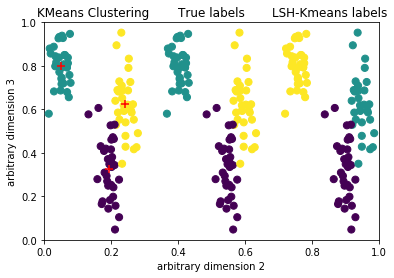

In [29]:
# pick two (random) dimensions to plot along
dim_1 = 2
dim_2 = 3
x = data[:,dim_1]
y = data[:,dim_2]

fig = plt.figure()

plt.xlabel('arbitrary dimension %d' % dim_1)
plt.ylabel('arbitrary dimension %d' % dim_2)

ax = fig.add_subplot(131, frameon=False)
scatter = ax.scatter(x,y,c=kmeans.labels_,s=50)
for i,j in kmeans.cluster_centers_[:,[dim_1, dim_2]]:
    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_title('KMeans Clustering')
ax.axis('off')
#plt.colorbar(scatter)

ax2 = fig.add_subplot(132, frameon=False)
scatter2 = ax2.scatter(x,y,c=labels,s=50)
ax2.set_title('True labels')
ax2.axis('off')

ax3 = fig.add_subplot(133, frameon=False)
scatter3 = ax3.scatter(x,y,c=kmeans_lsh.labels_,s=50)
ax3.set_title('LSH-Kmeans labels')
ax3.axis('off')

fig.show()

## 3. (b) Fly LSH on Facial dataset: Yale http://vision.ucsd.edu/content/yale-face-database

C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


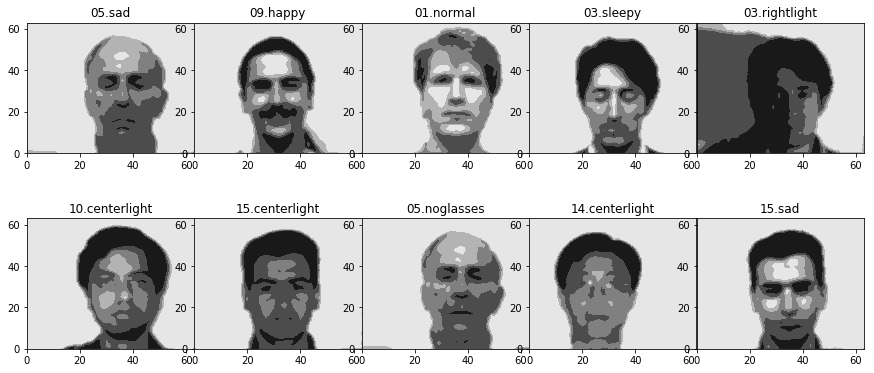

In [4]:
faces = [os.path.join("data","yalefaces", img) for img in os.listdir(os.path.join("data","yalefaces")) if img.startswith("subject")]
labels = [int(f.split("subject")[-1][:2]) for f in faces]
data = np.array([np.flipud(imread(faces[i])) for i in range(len(faces))])

# data are (243, 320), which is too large to handle
# without convolutions. so a resizing step is done here
data = [resize(img, (64, 64), anti_aliasing=True) for img in data]


# show some examples
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for i in range(10):

    rand = np.random.randint(len(faces), size=1)[0]
    axs[i].contourf(data[rand],5,cmap='gray') # upside down for some reason
    axs[i].set_title(faces[rand].split("subject")[-1])

plt.show()

In [5]:
face_fly = Flylsh(num_orn=data[0].ravel().shape[0], num_pn=data[0].ravel().shape[0], num_kc=data[0].ravel().shape[0]*20)
print("Finished face_fly setup")

function:  __init__ benchmark:  33.22396614492754 s
Finished face_fly setup


In [6]:
hashlens = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2]
hashes = []
i = 0
for hashlen in hashlens:
    for _ in data:
        face_fly.FeedForward(_, hashlen = hashlen)
        hashes.append(face_fly.apl)
        i += 1
    hashes = np.asarray(hashes)
    # this can take over 10 seconds per image; be warned! (30 minutes for the 166 images)
    # save hashes, because it takes forever
    pickle.dump( hashes, open( os.path.join("results", "face_hashes_hashlen_" + str(face_fly.hashlen) + "k.pkl"), "wb" ) )
    print("finished computing hashlen: %.3f" % hashlen)
    hashes =[]

finished computing hashlen: 0.001
finished computing hashlen: 0.005
finished computing hashlen: 0.010
finished computing hashlen: 0.025
finished computing hashlen: 0.050
finished computing hashlen: 0.100
finished computing hashlen: 0.200


## 3. (c) Comparison to standard K-Nearest-Neighbours

In [30]:
# load all saved hashes, and calculate accuracies
hashlens = ['0.001', '0.005', '0.01', '0.025', '0.05', '0.1', '0.2']
kmeans_acc = dict.fromkeys(hashlens)    # note that kmeans_acc is constant
lsh_acc = dict.fromkeys(hashlens)

for hashlen in hashlens:
    accuracies = {}
    lsh_hashes = []
    with open(os.path.join("results", "face_hashes_hashlen_" +hashlen + "k.pkl"), 'rb') as pickle_file:
        lsh_hashes = pickle.load(pickle_file)
        print("opening file: " + "face_hashes_hashlen_" +hashlen + "k.pkl" )
        
    #print("is lsh_hashes unique?: ", np.unique(np.asarray([hash.toarray() for hash in lsh_hashes])[:,:, 0]))
    kmeans = KMeans(n_clusters=15, random_state=42).fit(np.asarray([img.ravel() for img in data]))
    kmeans_lsh = KMeans(n_clusters=15, random_state=42).fit(np.asarray([hash.toarray() for hash in lsh_hashes])[:,:, 0])
    
    # determine accuracies of kmeans vs lsh+kmeans
    true_counts = np.bincount(labels)[1:,]    # drop the first zero count, we have no subj0
    idx = 0
    subj = 1
    kmeans_correct = {}    # count the consistency of clusters 
    lsh_correct = {}
    for true_count in true_counts:
        kmeans_cluster_count = np.bincount(kmeans.labels_[idx:idx+true_count])
        lsh_cluster_count = np.bincount(kmeans_lsh.labels_[idx:idx+true_count])

        subject = "subject" +str(subj)

        # for kmeans only
        kmeans_argmax = kmeans_cluster_count[kmeans_cluster_count.argmax()]    # is the max number consistent
        kmeans_s = np.sum(kmeans_cluster_count)
        assert kmeans_s == true_count    # if sum of cluster count isn't true count, we messed up
        assert kmeans_s-kmeans_argmax >= 0
        kmeans_correct[subject] = kmeans_s-kmeans_argmax

        # for lsh+kmeans
        lsh_argmax = lsh_cluster_count[lsh_cluster_count.argmax()]    # is the max number consistent
        lsh_s = np.sum(lsh_cluster_count)
        assert lsh_s == true_count    # if sum of cluster count isn't true count, we messed up
        assert lsh_s-lsh_argmax >= 0
        lsh_correct[subject] = lsh_s-kmeans_argmax    

        subj += 1
        idx += true_count 
        
    kmeans_acc[hashlen] = float(sum(kmeans_correct.values())/len(labels) * 100)
    lsh_acc[hashlen] = float(sum(lsh_correct.values())/len(labels) * 100)
    print("lsh correct counts are: ", lsh_correct.values())
    print("lsh acc for %s is %.2f" % (hashlen, float(sum(lsh_correct.values())/len(labels) * 100)))
    print("----------")

opening file: face_hashes_hashlen_0.001k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.001 is 49.00
----------
opening file: face_hashes_hashlen_0.005k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.005 is 49.00
----------
opening file: face_hashes_hashlen_0.01k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.01 is 49.00
----------
opening file: face_hashes_hashlen_0.025k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.025 is 49.00
----------
opening file: face_hashes_hashlen_0.05k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.05 is 49.00
----------
opening file: face_hashes_hashlen_0.1k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.1 is 49.00
----------
opening file: face_hashes_hashlen_0.2k.pkl
lsh correct counts are:  dict_values([23, 26])
lsh acc for 0.2 is 49.00
----------


In [34]:
lsh_acc

{'0.001': 49.0,
 '0.005': 49.0,
 '0.01': 49.0,
 '0.025': 49.0,
 '0.05': 49.0,
 '0.1': 49.0,
 '0.2': 49.0}